In [1]:
import sys, os, numpy as np, random, time
import matplotlib.pyplot as plt, seaborn as sns, joblib, pickle

from datetime import datetime
from itertools import combinations
from typing import List, Tuple, Dict, Any, Optional

In [2]:
# CLASSE DE BASE ENVIRONNEMENT

from abc import ABC, abstractmethod

class BaseEnvironment(ABC):
    
    @abstractmethod
    def reset(self):
        pass
    
    @abstractmethod
    def step(self, action, is_dynamic_programming=False):
        pass
    
    @property
    @abstractmethod
    def _build_transition_matrix(self):
        pass
    
    @property
    @abstractmethod
    def _build_reward_matrix(self):
        pass

In [3]:
# UTILITAIRES POUR SAUVEGARDE
def save_model(data: Dict[str, Any], filepath: str, format: str = 'pickle') -> None:
    """Sauvegarde un modèle dans le format spécifié."""
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    
    if format == 'pickle':
        with open(filepath, 'wb') as f:
            pickle.dump(data, f)
    elif format == 'joblib':
        if not JOBLIB_AVAILABLE:
            raise ImportError("joblib n'est pas disponible.")
        joblib.dump(data, filepath)
    else:
        raise ValueError(f"Format '{format}' non supporté.")

def load_model(filepath: str, format: str = 'auto') -> Dict[str, Any]:
    """Charge un modèle depuis le format spécifié."""
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Le fichier {filepath} n'existe pas.")
    
    if format == 'auto':
        extension = os.path.splitext(filepath)[1].lower()
        format = 'pickle' if extension == '.pkl' else 'joblib'
    
    if format == 'pickle':
        with open(filepath, 'rb') as f:
            return pickle.load(f)
    elif format == 'joblib':
        if not JOBLIB_AVAILABLE:
            raise ImportError("joblib n'est pas disponible.")
        return joblib.load(filepath)
    else:
        raise ValueError(f"Format '{format}' non supporté.")


In [4]:
# ALGORITHME POLICY ITERATION

class PolicyIteration:
    """
    Implémentation de l'algorithme Policy Iteration.
    
    Policy Iteration alterne entre l'évaluation de politique et l'amélioration
    de politique jusqu'à convergence vers la politique optimale.
    """
    
    def __init__(self, env: Any, gamma: float = 0.9, theta: float = 1e-6):
        """
        Initialise Policy Iteration.
        
        Args:
            env: Environnement MDP
            gamma: Facteur de discount
            theta: Seuil de convergence pour l'évaluation de politique
        """
        self.env = env
        self.gamma = gamma
        self.theta = theta
        self.V = None
        self.policy = None
        self.history = []
        
    def policy_evaluation(self, policy: np.ndarray) -> np.ndarray:
        """
        Évalue une politique donnée.
        
        Args:
            policy: Politique à évaluer (actions pour chaque état)
            
        Returns:
            Fonction de valeur d'état
        """
        V = np.copy(self.V) if self.V is not None else np.random.random((self.n_states,))
        
        # Les états terminaux ont une valeur de 0
        if hasattr(self, 'terminal_states'):
            V[self.terminal_states] = 0.0
        
        while True:
            delta = 0.0
            
            for s in self.states:
                v = V[s]
                total = 0.0
                
                # Calculer la valeur pour l'action dictée par la politique
                action = policy[s]
                
                if hasattr(self, 'reward_matrix') and self.reward_matrix is not None:
                    # Nouveau format avec reward_matrix (même logique que ValueIteration)
                    for s_p in self.states:
                        prob = self.transition_probs[s, action, s_p]
                        reward = self.reward_matrix[s, action]
                        total += prob * (reward + self.gamma * V[s_p])
                else:
                    # Ancien format avec récompenses multiples
                    for s_p in self.states:
                        for r_index in range(len(self.rewards)):
                            r = self.rewards[r_index]
                            prob = self.transition_probs[s, action, s_p, r_index]
                            total += prob * (r + self.gamma * V[s_p])
                
                V[s] = total
                abs_diff = np.abs(v - V[s])
                delta = np.maximum(delta, abs_diff)
            
            if delta < self.theta:
                break
        
        return V
        
    def policy_improvement(self, V: np.ndarray) -> np.ndarray:
        """
        Améliore la politique basée sur la fonction de valeur.
        
        Args:
            V: Fonction de valeur d'état
            
        Returns:
            Politique améliorée
        """
        new_policy = np.copy(self.policy)
        policy_stable = True
        
        for s in self.states:
            old_action = new_policy[s]
            best_action = None
            best_score = -np.inf
            
            # Évaluer toutes les actions possibles
            for a in self.actions:
                score = 0.0
                
                if hasattr(self, 'reward_matrix') and self.reward_matrix is not None:
                    # Nouveau format avec reward_matrix (même logique que ValueIteration)
                    for s_p in self.states:
                        prob = self.transition_probs[s, a, s_p]
                        reward = self.reward_matrix[s, a]
                        score += prob * (reward + self.gamma * V[s_p])
                else:
                    # Ancien format avec récompenses multiples
                    for s_p in self.states:
                        for r_index in range(len(self.rewards)):
                            r = self.rewards[r_index]
                            prob = self.transition_probs[s, a, s_p, r_index]
                            score += prob * (r + self.gamma * V[s_p])
                
                if best_action is None or score > best_score:
                    best_action = a
                    best_score = score
            
            if best_action != old_action:
                policy_stable = False
            
            new_policy[s] = best_action
        
        return new_policy, policy_stable
        
    def train(self, max_iterations: int = 1000) -> Dict[str, Any]:
        """
        Entraîne l'algorithme Policy Iteration.
        
        Args:
            max_iterations: Nombre maximum d'itérations
            
        Returns:
            Dictionnaire contenant les résultats d'entraînement
        """
        # Initialiser les structures nécessaires
        self._initialize_mdp_structures()
        
        # Initialiser V et politique
        self.V = np.random.random((self.n_states,))
        if hasattr(self, 'terminal_states'):
            self.V[self.terminal_states] = 0.0
        
        # Politique initiale aléatoire
        self.policy = np.array([np.random.choice(self.actions) for _ in self.states])
        if hasattr(self, 'terminal_states'):
            self.policy[self.terminal_states] = 0
        
        # Historique d'entraînement
        self.history = []
        
        iteration = 0
        while iteration < max_iterations:
            iteration += 1
            
            # 1. Policy Evaluation
            self.V = self.policy_evaluation(self.policy)
            
            # 2. Policy Improvement
            new_policy, policy_stable = self.policy_improvement(self.V)
            
            # Enregistrer les statistiques
            avg_value = np.mean(self.V)
            max_value = np.max(self.V)
            
            self.history.append({
                'iteration': iteration,
                'avg_value': avg_value,
                'max_value': max_value,
                'policy_stable': policy_stable
            })
            
            # Mise à jour de la politique
            self.policy = new_policy
            
            # Vérifier la convergence
            if policy_stable:
                print(f"Convergence atteinte après {iteration} itérations")
                break
        
        return {
            'policy': self.policy,
            'V': self.V,
            'history': self.history,
            'iterations': iteration,
            'converged': policy_stable if 'policy_stable' in locals() else False
        }
    
    def _initialize_mdp_structures(self):
        """
        Initialise les structures nécessaires pour un MDP.
        """
        if hasattr(self.env, 'get_mdp_info'):
            # Utiliser les informations fournies par l'environnement
            mdp_info = self.env.get_mdp_info()
            self.states = list(mdp_info['states'])
            self.actions = mdp_info['actions']
            self.n_states = len(self.states)
            self.n_actions = len(self.actions)
            self.terminal_states = mdp_info['terminals']
            self.transition_probs = mdp_info['transition_matrix']
            self.reward_matrix = mdp_info['reward_matrix']
            self.rewards = [0.0, 1.0]  # Garde pour compatibilité avec l'ancien format
            
        elif hasattr(self.env, 'nS') and hasattr(self.env, 'nA'):
            # Environnement gym discret (comme FrozenLake)
            self.n_states = self.env.nS
            self.n_actions = self.env.nA
            self.states = list(range(self.n_states))
            self.actions = list(range(self.n_actions))
            
            # Initialiser les récompenses possibles
            self.rewards = [0.0, 1.0]  # À adapter selon votre environnement
            
            # Initialiser les probabilités de transition
            self._initialize_transition_probabilities()
            
        else:
            # Environnement générique - à adapter
            self.n_states = getattr(self.env, 'observation_space', type('obj', (object,), {'n': 16})).n
            self.n_actions = getattr(self.env, 'action_space', type('obj', (object,), {'n': 4})).n
            self.states = list(range(self.n_states))
            self.actions = list(range(self.n_actions))
            self.rewards = [0.0, 1.0]
            
            # Probabilités de transition par défaut (à adapter)
            self.transition_probs = np.ones((self.n_states, self.n_actions, self.n_states, len(self.rewards))) / (self.n_states * len(self.rewards))
    
    def _initialize_transition_probabilities(self):
        """
        Initialise les probabilités de transition depuis l'environnement.
        """
        self.transition_probs = np.zeros((self.n_states, self.n_actions, self.n_states, len(self.rewards)))
        
        # Si l'environnement a des probabilités de transition accessibles
        if hasattr(self.env, 'P'):
            for s in self.states:
                for a in self.actions:
                    if s in self.env.P and a in self.env.P[s]:
                        for prob, next_state, reward, done in self.env.P[s][a]:
                            # Trouver l'index de la récompense
                            r_index = 0
                            if reward in self.rewards:
                                r_index = self.rewards.index(reward)
                            else:
                                # Ajouter la nouvelle récompense
                                self.rewards.append(reward)
                                r_index = len(self.rewards) - 1
                                # Redimensionner le tableau des probabilités
                                new_shape = (self.n_states, self.n_actions, self.n_states, len(self.rewards))
                                new_probs = np.zeros(new_shape)
                                new_probs[:, :, :, :-1] = self.transition_probs
                                self.transition_probs = new_probs
                            
                            self.transition_probs[s, a, next_state, r_index] = prob
        else:
            # Distribution uniforme par défaut
            uniform_prob = 1.0 / (self.n_states * len(self.rewards))
            self.transition_probs.fill(uniform_prob)
        
    def save(self, filepath: str):
        """Sauvegarde le modèle."""
        model_data = {
            'V': self.V,
            'policy': self.policy,
            'gamma': self.gamma,
            'theta': self.theta,
            'history': self.history
        }
        save_model(model_data, filepath)
        
    def load(self, filepath: str):
        """Charge un modèle sauvegardé."""
        model_data = load_model(filepath)
        self.V = model_data['V']
        self.policy = model_data['policy']
        self.gamma = model_data['gamma']
        self.theta = model_data['theta']
        self.history = model_data['history']


In [5]:
# ENVIRONNEMENT LINE WORLD

class LineWorld(BaseEnvironment):
    def __init__(self, length=8):
        self.length = length
        self.start = length // 2
        self.terminals = [0, length-1]
        self.actions = [0, 1]
        self.reset()

        # Matrice de transition et récompenses pour les algorithmes de programmation dynamique
        self._transition_matrix = self._build_transition_matrix()
        self._reward_matrix = self._build_reward_matrix()

        # Métriques
        self.episode_count = 0
        self.steps_count = 0
        self.total_reward = 0
        self.visited_states = set()
        self.episode_history = []

    def reset(self):
        # Réinitialisation de l'environnement
        self.state = self.start
        return self.state

    def step(self, action, is_dynamic_programming=False):
        current_state = self.state
    
        # Calcul du prochain état
        if action == 0:  # Gauche
            reward = -1.0
            next_state = max(0, self.state - 1)
        else:  # Droite
            reward = 1.0
            next_state = min(self.length-1, self.state + 1)

        # Vérification du milieu APRÈS le calcul du next_state
        if next_state == self.length // 2:
            reward = 0.0

        done = next_state in self.terminals
        self.state = next_state

        if is_dynamic_programming:
            return {
                'state': self.state,
                'previous_state': current_state,
                'action': action
            }, reward, done
        else:
            return next_state, reward, done, {
                'action_name': 'gauche' if action == 0 else 'droite',
                'position': self.state,
                'previous_position': current_state
            }

    def visualisation(self):
        # Visualisation de notre environnement
        print("\n" + "="*40)
        line = ["[ ]"] * self.length
        line[self.state] = "[A]"  # Position de l'agent
        line[0] = "[T]"  # Terminal gauche
        line[-1] = "[T]"  # Terminal droit
        print(" ".join(line))
        
        # On affiche les indices pour mieux comprendre
        indices = [f"{i:^3}" for i in range(self.length)]
        print(" ".join(indices))
        print("="*40)

    def _build_transition_matrix(self):
        # Construit la matrice de transition P(s'|s,a).
        P = np.zeros((self.length, len(self.actions), self.length))
        
        for s in range(self.length):
            # Action gauche (0)
            next_s = max(0, s - 1)
            P[s, 0, next_s] = 1.0
            
            # Action droite (1)
            next_s = min(self.length-1, s+1)
            P[s, 1, next_s] = 1.0
            
        return P

    def _build_reward_matrix(self):
        # Construit la matrice de récompense R(s,a).
        R = np.zeros((self.length, len(self.actions)))
        
        for s in range(self.length):
            # Action gauche
            next_s_left = max(0, s-1)
            if next_s_left in self.terminals:
                R[s, 0] = 1.0

            # Action droite (1)
            next_s_right = min(self.length-1, s+1)
            if next_s_right in self.terminals:
                R[s, 1] = 1.0
                
        return R

    def get_mdp_info(self):
        # Retourne les informations du MDP
        return {
            'states': range(self.length),
            'actions': self.actions,
            'transition_matrix': self._transition_matrix,
            'reward_matrix': self._reward_matrix,
            'terminals': self.terminals,
            'gamma': 0.99  
        }

    def get_state_space(self):
        return range(self.length)

    def get_action_space(self):
        return self.actions

    @property
    def transition_matrix(self):
        return self._transition_matrix

    @property
    def reward_matrix(self):
        return self._reward_matrix


In [6]:
class GridWorld(BaseEnvironment):
    def __init__(self, n_rows=5, n_cols=5):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_states = n_rows * n_cols

        # Métriques sup
        self.steps_count = 0
        self.total_reward = 0
        self.visited_states = set()
        
        # Définition des actions : 0: Gauche, 1: Droite, 2: Haut, 3: Bas
        self.actions = [0, 1, 2, 3]
        
        # Les états terminaux sont dans les coins supérieur gauche et inférieur droit de la grille
        self.terminals = [0, self.n_states - 1]
        
        # CORRECTION: Récompenses équilibrées pour favoriser l'atteinte des terminaux
        self.rewards = {
            'movement': -0.1,  # Déplacement normal (petit coût pour favoriser l'efficacité)
            'middle': -1.0,    # Vers le milieu (pénalité modérée)
            'no_move': -0.5,   # Pas de mouvement possible
            'terminal': 10.0   # AJOUT: Récompense positive importante pour atteindre un terminal
        }
        
        # Position initiale (centre de la grille)
        self.start_row = self.n_rows // 2
        self.start_col = self.n_cols // 2
        self.start_state = self._pos_to_state(self.start_row, self.start_col)
        
        # Spécifique à la programmation dynamique
        self._transition_matrix = self._build_transition_matrix()
        self._reward_matrix = self._build_reward_matrix()
        
        # Initialisation
        self.reset()

    def reset(self):
        # Réinitialisation de l'environnement
        self.current_state = self.start_state
        self.done = False
        return self.current_state

    def step(self, action, for_dp=False):
        # Cette méthode est utilisée pour exécuter une action et retourner le résultat
        current_row, current_col = self._state_to_pos(self.current_state)
        new_row, new_col = current_row, current_col
        
        # Calcul de la nouvelle position
        if action == 0 and current_col > 0:  # Gauche
            new_col -= 1
        elif action == 1 and current_col < self.n_cols - 1:  # Droite
            new_col += 1
        elif action == 2 and current_row > 0:  # Haut
            new_row -= 1
        elif action == 3 and current_row < self.n_rows - 1:  # Bas
            new_row += 1
            
        next_state = self._pos_to_state(new_row, new_col)
        
        # CORRECTION: Calcul de la récompense avec bonus terminal
        if next_state in self.terminals:
            reward = self.rewards['terminal']  # Grande récompense pour atteindre un terminal
        elif (new_row, new_col) == (current_row, current_col):
            reward = self.rewards['no_move']
        elif next_state == self.start_state:
            reward = self.rewards['middle']
        else:
            reward = self.rewards['movement']
            
        self.done = next_state in self.terminals
        self.current_state = next_state
        
        # Mise à jour des métriques
        self.steps_count += 1
        self.total_reward += reward
        self.visited_states.add(next_state)

        if for_dp:
            return {
                'state': self.current_state,
                'position': (new_row, new_col),
                'previous_position': (current_row, current_col)
            }, reward, self.done
        else:
            return next_state, reward, self.done, {
                'position': (new_row, new_col),
                'action_name': ['gauche', 'droite', 'haut', 'bas'][action]
            }

    def _pos_to_state(self, row, col):
        # Convertit une position (row, col) en numéro d'état
        return row * self.n_cols + col

    def _state_to_pos(self, state):
        # Convertit un numéro d'état en position (row, col)
        return divmod(state, self.n_cols)

    def _build_transition_matrix(self):
        # Construit la matrice de transition P(s'|s,a)
        P = np.zeros((self.n_states, len(self.actions), self.n_states))
        
        for s in range(self.n_states):
            if s in self.terminals:
                # CORRECTION: Les états terminaux restent terminaux
                P[s, :, s] = 1.0
                continue
                
            row, col = self._state_to_pos(s)
            
            for a in self.actions:
                new_row, new_col = row, col
                
                if a == 0 and col > 0:
                    new_col -= 1
                elif a == 1 and col < self.n_cols - 1:
                    new_col += 1
                elif a == 2 and row > 0:
                    new_row -= 1
                elif a == 3 and row < self.n_rows - 1:
                    new_row += 1
                    
                next_state = self._pos_to_state(new_row, new_col)
                P[s, a, next_state] = 1.0
                
        return P

    def _build_reward_matrix(self):
        # CORRECTION: Construit la matrice des récompenses avec bonus terminal
        R = np.zeros((self.n_states, len(self.actions)))
        
        for s in range(self.n_states):
            if s in self.terminals:
                # Les états terminaux n'ont pas de récompenses d'actions
                continue
                
            row, col = self._state_to_pos(s)
            
            for a in self.actions:
                new_row, new_col = row, col
                
                if a == 0 and col > 0:
                    new_col -= 1
                elif a == 1 and col < self.n_cols - 1:
                    new_col += 1
                elif a == 2 and row > 0:
                    new_row -= 1
                elif a == 3 and row < self.n_rows - 1:
                    new_row += 1
                    
                next_state = self._pos_to_state(new_row, new_col)
                
                # CORRECTION: Récompense positive pour atteindre les terminaux
                if next_state in self.terminals:
                    R[s, a] = self.rewards['terminal']
                elif (new_row, new_col) == (row, col):
                    R[s, a] = self.rewards['no_move']
                elif next_state == self.start_state:
                    R[s, a] = self.rewards['middle']
                else:
                    R[s, a] = self.rewards['movement']
        
        return R

    def get_mdp_info(self):
        # Retourne les informations du MDP pour les algorithmes de Dynamic Programming
        return {
            'states': range(self.n_states),
            'actions': self.actions,
            'transition_matrix': self._transition_matrix,
            'reward_matrix': self._reward_matrix,
            'terminals': self.terminals,
            'gamma': 0.99
        }

    def visualisation(self):
        # Affiche l'état actuel de notre environnement
        print("\n" + "="*40)
        print("Grid World CORRIGÉ".center(40))
        print("-"*40)
        
        grid = [['[ ]' for _ in range(self.n_cols)] for _ in range(self.n_rows)]
        
        # Marquer les terminaux
        for terminal in self.terminals:
            term_row, term_col = self._state_to_pos(terminal)
            grid[term_row][term_col] = '[T]'
        
        # Position actuelle
        agent_row, agent_col = self._state_to_pos(self.current_state)
        grid[agent_row][agent_col] = '[A]'
        
        # Afficher la grille avec bordures
        print('+' + '---+'*self.n_cols)
        for grid_row in grid:
            print('|' + '|'.join(grid_row) + '|')
            print('+' + '---+'*self.n_cols)
        
        print(f"Position de l'agent : ({agent_row},{agent_col})")
        print("="*40)

    def get_state_space(self):
        return range(self.n_states)

    def get_action_space(self):
        return self.actions

    @property
    def transition_matrix(self):
        return self._transition_matrix

    @property
    def reward_matrix(self):
        return self._reward_matrix

In [7]:
class RockPaperScissors:
    # États du jeu
    INITIAL_STATE = 0
    ROUND1_START = 1
    ROUND2_START = 4
    TERMINAL_DP = 7
    TERMINAL_MC = 8

    def __init__(self):
        self.actions = [0, 1, 2]
        self.n_actions = len(self.actions)
        self.n_states = 9

        # Matrice du jeu de base
        self.reward_matrix = np.array([
            [0, -1, 1],   # Pierre
            [1, 0, -1],   # Feuille
            [-1, 1, 0]    # Ciseaux
        ])

        self.agent_action_round1 = None
        self.transition_matrix = self._build_transition_matrix()
        self.reward_matrix_dp = self._build_reward_matrix()

        self.steps_count = 0
        self.total_reward = 0
        self.wins = 0
        self.total_games = 0
        self.reset()

    def reset(self):
        self.current_round = 0
        self.previous_agent_action = None
        self.previous_opponent_action = None
        self.agent_action_round1 = None
        self.done = False
        self.steps_count = 0
        self.total_reward = 0
        return self._get_state()

    def step(self, action, is_dynamic_programming=False):
        if self.current_round == 0:
            opponent_action = random.choice(self.actions)
            self.agent_action_round1 = action
        else:
            opponent_action = self.agent_action_round1
            
        reward = self.reward_matrix[action, opponent_action]
        
        self.previous_agent_action = action
        self.previous_opponent_action = opponent_action
        self.current_round += 1
        self.done = self.current_round >= 2
        
        self.steps_count += 1
        self.total_reward += reward
        if reward > 0:
            self.wins += 1
        if self.done:
            self.total_games += 1

        if is_dynamic_programming:
            return self._get_state(for_dp=True), reward, self.done
        else:
            return self._get_state(for_dp=False), reward, self.done, {
                'round': self.current_round,
                'agent_action': action,
                'opponent_action': opponent_action
            }

    def _get_state(self, for_dp=False):
        if for_dp:
            if self.current_round == 0:
                return self.INITIAL_STATE
            elif self.current_round == 1:
                return self.ROUND1_START + self.previous_opponent_action
            elif self.current_round == 2 and not self.done:
                return self.ROUND2_START + self.agent_action_round1
            else:
                return self.TERMINAL_DP
        else:
            if self.current_round == 0:
                return self.INITIAL_STATE
            elif self.current_round == 1:
                return self.ROUND1_START + self.previous_opponent_action
            elif self.current_round == 2 and not self.done:
                return self.ROUND2_START + self.agent_action_round1
            else:
                return self.TERMINAL_MC

    def _build_transition_matrix(self):
        P = np.zeros((self.n_states, self.n_actions, self.n_states))
        
        # Depuis l'état initial (0)
        for action in self.actions:
            for opp_action in self.actions:
                next_state = self.ROUND1_START + opp_action
                P[self.INITIAL_STATE, action, next_state] = 1/3
        
        # Depuis les états après premier round (1-3)
        for state in range(self.ROUND1_START, self.ROUND2_START):
            for action in self.actions:
                next_state = self.ROUND2_START + action
                P[state, action, next_state] = 1.0
        
        # Depuis les états du second round (4-6)
        for state in range(self.ROUND2_START, self.TERMINAL_DP):
            for action in self.actions:
                P[state, action, self.TERMINAL_DP] = 1.0
        
        return P

    def _build_reward_matrix(self):
        R = np.zeros((self.n_states, self.n_actions))
        
        # APPROCHE 1: Récompenses asymétriques à l'état initial
        # Simuler une légère préférence sans donner la solution optimale
        R[self.INITIAL_STATE, 0] = 0.5   # Pierre légèrement avantagé
        R[self.INITIAL_STATE, 1] = 0.3   # Feuille intermédiaire  
        R[self.INITIAL_STATE, 2] = 0.1   # Ciseaux moins avantagé
        
        # États 1-3: Récompenses du round 1 seulement
        for state in range(self.ROUND1_START, self.ROUND2_START):
            opponent_action = state - self.ROUND1_START
            for action in self.actions:
                R[state, action] = self.reward_matrix[action, opponent_action]
        
        # États 4-6: Récompenses du round 2
        for state in range(self.ROUND2_START, self.TERMINAL_DP):
            agent_previous_action = state - self.ROUND2_START
            for action in self.actions:
                R[state, action] = self.reward_matrix[action, agent_previous_action]
        
        return R

    def get_mdp_info(self):
        return {
            'states': range(self.n_states),
            'actions': self.actions,
            'transition_matrix': self.transition_matrix,
            'reward_matrix': self.reward_matrix_dp,
            'terminals': [self.TERMINAL_DP],
            'gamma': 0.9
        }

In [8]:
# ENVIRONNEMENT MONTY HALL PARADOX 1

class MontyHallParadox1(BaseEnvironment):
    def __init__(self):
        # Configuration du jeu
        self.doors = [0, 1, 2]  # Portes A, B, C
        self.R = [0.0, 1.0]  # Récompenses possibles
        self.A = [0, 1]  # 0: rester, 1: changer
        
        # État INTERNE (caché à l'agent) - pour la simulation du jeu
        self._winning_door = None  # Information cachée
        self._revealed_door = None
        self._first_choice = None
        
        # État OBSERVABLE par l'agent (sans information de la porte gagnante)
        self.current_state = None  # (chosen, revealed) ou état initial
        
        # Métriques de performance
        self.total_games = 0
        self.wins = 0
        self.stay_wins = 0
        self.switch_wins = 0
        self.total_reward = 0
        
        # Construction des matrices pour DP avec nouveaux états
        self.states, self.state_to_idx = self._build_states()
        self._transition_matrix = self._build_transition_matrix()
        self._reward_matrix = self._build_reward_matrix()
        
        # Maintenant on peut faire un vrai reset
        self.reset()

    def reset(self):
        """Réinitialise l'environnement pour un nouvel épisode."""
        self._winning_door = random.choice(self.doors)
        self._revealed_door = None
        self._first_choice = None
        
        # État observable : juste un indicateur qu'on est au début
        self.current_state = "initial"  
        return self.current_state

    def step(self, action, is_dynamic_programming=False):
        """Exécute une action dans l'environnement."""
        if self.current_state == "terminal":
            return self.current_state, 0.0, True, {}
        
        # Phase 1: Premier choix de porte
        if self.current_state == "initial":
            if action not in self.doors:
                raise ValueError(f"Action invalide {action}. Doit être entre 0 et 2.")
                
            # Révéler une porte non gagnante différente du choix
            available_doors = [d for d in self.doors if d != action and d != self._winning_door]
            self._revealed_door = random.choice(available_doors) if available_doors else None
            
            self._first_choice = action
            
            # État observable : seulement le choix et la porte révélée
            next_state = (action, self._revealed_door)
            
            if is_dynamic_programming:
                return next_state, 0.0, False
            
            self.current_state = next_state
            return next_state, 0.0, False, {
                'phase': 1,
                'door_chosen': ['A', 'B', 'C'][action],
                'door_revealed': ['A', 'B', 'C'][self._revealed_door] if self._revealed_door is not None else None
            }
            
        # Phase 2: Décision de rester ou changer
        if action not in self.A:
            raise ValueError(f"Action invalide {action}. Doit être 0 (rester) ou 1 (changer).")
            
        chosen, revealed = self.current_state
        remaining = [d for d in self.doors if d != chosen and d != revealed][0]
        final_choice = chosen if action == 0 else remaining
        reward = 1.0 if final_choice == self._winning_door else 0.0
        
        if not is_dynamic_programming:
            # Mise à jour des métriques
            self.total_games += 1
            self.total_reward += reward
            if reward == 1.0:
                self.wins += 1
                if action == 0:
                    self.stay_wins += 1
                else:
                    self.switch_wins += 1
        
        next_state = "terminal"
        self.current_state = next_state
        
        if is_dynamic_programming:
            return next_state, reward, True
            
        return next_state, reward, True, {
            'phase': 2,
            'final_choice': ['A', 'B', 'C'][final_choice],
            'winning_door': ['A', 'B', 'C'][self._winning_door],
            'action': 'resté' if action == 0 else 'changé'
        }

    def _build_states(self):
        """Construit la liste des états OBSERVABLES et leur mapping vers des indices."""
        states = []
        state_to_idx = {}
        
        # État initial observable
        state = "initial"
        states.append(state)
        state_to_idx[state] = len(states) - 1
        
        # Phase 2 : États (chosen, revealed) - l'agent ne voit que ça
        for chosen in self.doors:
            for revealed in self.doors:
                if revealed != chosen:  # La porte révélée ne peut pas être celle choisie
                    state = (chosen, revealed)
                    states.append(state)
                    state_to_idx[state] = len(states) - 1
        
        # État terminal
        terminal_state = "terminal"
        states.append(terminal_state)
        state_to_idx[terminal_state] = len(states) - 1
        
        return states, state_to_idx

    def _build_transition_matrix(self):
        """Construit la matrice de transition P(s'|s,a) avec les nouveaux états."""
        n_states = len(self.states)
        n_actions = max(len(self.doors), len(self.A))
        P = np.zeros((n_states, n_actions, n_states))
        
        # Depuis l'état initial
        initial_idx = self.state_to_idx["initial"]
        for action in self.doors:
            # Pour chaque porte gagnante possible (équiprobable)
            for winning_door in self.doors:
                if action == winning_door:
                    # Si on choisit la porte gagnante, Monty peut révéler n'importe laquelle des autres
                    available_reveals = [d for d in self.doors if d != action]
                    for reveal in available_reveals:
                        next_state = (action, reveal)
                        next_idx = self.state_to_idx[next_state]
                        P[initial_idx, action, next_idx] += (1/3) * (1/len(available_reveals))
                else:
                    # Si on ne choisit pas la porte gagnante, Monty révèle l'autre porte non-gagnante
                    reveal = [d for d in self.doors if d != action and d != winning_door][0]
                    next_state = (action, reveal)
                    next_idx = self.state_to_idx[next_state]
                    P[initial_idx, action, next_idx] += (1/3)
        
        # Depuis les états de phase 2
        terminal_idx = self.state_to_idx["terminal"]
        for state in self.states:
            if isinstance(state, tuple) and len(state) == 2:  # États (chosen, revealed)
                state_idx = self.state_to_idx[state]
                for action in self.A:
                    P[state_idx, action, terminal_idx] = 1.0
        
        return P

    def _build_reward_matrix(self):
        """Construit la matrice de récompense R(s,a) avec les nouveaux états."""
        n_states = len(self.states)
        n_actions = max(len(self.doors), len(self.A))
        R = np.zeros((n_states, n_actions))
        
        # Les récompenses ne sont données qu'en phase 2
        for state in self.states:
            if isinstance(state, tuple) and len(state) == 2:  # États (chosen, revealed)
                state_idx = self.state_to_idx[state]
                chosen, revealed = state
                remaining = [d for d in self.doors if d != chosen and d != revealed][0]
                
                # Action 0 (rester) : récompense si chosen est gagnante
                R[state_idx, 0] = 1/3  # Espérance de gain en restant
                R[state_idx, 1] = 2/3  # Espérance de gain en changeant
        
        return R

    @property
    def transition_matrix(self):
        return self._transition_matrix

    @property  
    def reward_matrix(self):
        return self._reward_matrix

    def get_mdp_info(self):
        """Retourne les informations du MDP pour les algorithmes de DP."""
        return {
            'states': range(len(self._transition_matrix)),
            'actions': self.A,
            'transition_matrix': self._transition_matrix,
            'reward_matrix': self._reward_matrix,
            'terminals': [len(self._transition_matrix) - 1],  # Dernier état = terminal
            'gamma': 0.99
        }


In [9]:
# ENVIRONNEMENT MONTY HALL PARADOX 2

class MontyHallParadox2(BaseEnvironment):
    def __init__(self):
        # Configuration du jeu
        self.doors = [0, 1, 2, 3, 4]  # 5 Portes A, B, C, D, E
        self.R = [0.0, 1.0]  # Récompenses possibles
        self.A = [0, 1]  # 0: rester, 1: changer
        
        # État INTERNE (caché à l'agent) - pour la simulation du jeu
        self._winning_door = None  # Information cachée
        self._revealed_doors = []  # Portes révélées par Monty
        self._current_choice = None  # Porte actuellement choisie
        self._phase = 0  # Phase du jeu (0-3)
        
        # État OBSERVABLE par l'agent (sans information de la porte gagnante)
        self.current_state = None  # État observable par l'agent
        
        # Métriques de performance
        self.total_games = 0
        self.wins = 0
        self.stay_wins = 0
        self.switch_wins = 0
        self.total_reward = 0
        
        # Construction des matrices pour DP avec nouveaux états
        self.states, self.state_to_idx = self._build_states()
        self.transition_matrix = self._build_transition_matrix()
        self.reward_matrix = self._build_reward_matrix()
        
        # Maintenant on peut faire un vrai reset
        self.reset()

    def reset(self):
        """Réinitialise l'environnement pour un nouvel épisode."""
        self._winning_door = random.choice(self.doors)
        self._revealed_doors = []
        self._current_choice = None
        self._phase = 0
        
        # État observable : juste un indicateur qu'on est au début
        self.current_state = "initial"
        return self.current_state

    def step(self, action, is_dynamic_programming=False):
        """Exécute une action dans l'environnement."""
        if self.current_state == "terminal":
            return self.current_state, 0.0, True, {}
            
        # Phase finale (4ème action) - décision rester/changer
        if self._phase == 3:
            if action not in self.A:
                raise ValueError(f"Phase finale : l'action doit être 0 (rester) ou 1 (changer), pas {action}")
            
            available = [d for d in self.doors if d not in self._revealed_doors and d != self._current_choice]
            final_choice = self._current_choice if action == 0 else available[0]
            reward = 1.0 if final_choice == self._winning_door else 0.0
            
            if not is_dynamic_programming:
                self.total_games += 1
                self.total_reward += reward
                if reward == 1.0:
                    self.wins += 1
                    if action == 0:
                        self.stay_wins += 1
                    else:
                        self.switch_wins += 1
            
            next_state = "terminal"
            self.current_state = next_state
            
            if is_dynamic_programming:
                return next_state, reward, True
                
            return next_state, reward, True, {
                'phase': self._phase + 1,
                'final_choice': ['A', 'B', 'C', 'D', 'E'][final_choice],
                'winning_door': ['A', 'B', 'C', 'D', 'E'][self._winning_door],
                'action': 'resté' if action == 0 else 'changé'
            }
        
        # Phases 1-3 : Choix de portes
        if action not in self.doors:
            raise ValueError(f"Phase {self._phase + 1} : l'action doit être une porte (0-4), pas {action}")
        
        if action in self._revealed_doors:
            raise ValueError(f"Phase {self._phase + 1} : la porte {['A', 'B', 'C', 'D', 'E'][action]} a déjà été révélée!")
            
        # Mise à jour du choix courant
        self._current_choice = action
        
        # Révélation d'une nouvelle porte par Monty
        available_for_reveal = [d for d in self.doors 
                               if d != action and d != self._winning_door and d not in self._revealed_doors]
        if available_for_reveal:
            revealed = random.choice(available_for_reveal)
            self._revealed_doors.append(revealed)
        
        self._phase += 1
        
        # État observable : (phase, current_choice, revealed_doors) - sans winning_door
        next_state = (self._phase, self._current_choice, tuple(sorted(self._revealed_doors)))
        
        if is_dynamic_programming:
            return next_state, 0.0, False
        
        self.current_state = next_state
        return next_state, 0.0, False, {
            'phase': self._phase,
            'door_chosen': ['A', 'B', 'C', 'D', 'E'][action],
            'door_revealed': ['A', 'B', 'C', 'D', 'E'][revealed] if available_for_reveal else None
        }

    def _build_states(self):
        """Construit la liste des états OBSERVABLES et leur mapping vers des indices."""
        states = []
        state_to_idx = {}
        
        # État initial observable
        state = "initial"
        states.append(state)
        state_to_idx[state] = len(states) - 1
        
        # États intermédiaires : (phase, current_choice, revealed_doors)
        # Phase 1-3, pour chaque combinaison possible
        for phase in range(1, 4):
            for current_choice in self.doors:
                # Générer toutes les combinaisons possibles de portes révélées pour cette phase
                for revealed_combo in combinations([d for d in self.doors if d != current_choice], phase):
                    state = (phase, current_choice, tuple(sorted(revealed_combo)))
                    states.append(state)
                    state_to_idx[state] = len(states) - 1
        
        # État terminal
        terminal_state = "terminal"
        states.append(terminal_state)
        state_to_idx[terminal_state] = len(states) - 1
        
        return states, state_to_idx

    def _build_transition_matrix(self):
        """Construit la matrice de transition P(s'|s,a) avec les nouveaux états."""
        n_states = len(self.states)
        n_actions = len(self.doors)  # Maximum entre choix de portes et rester/changer
        P = np.zeros((n_states, n_actions, n_states))
        
        # Depuis l'état initial - choix de la première porte
        initial_idx = self.state_to_idx["initial"]
        for action in self.doors:
            # Pour chaque porte gagnante possible (équiprobable)
            for winning_door in self.doors:
                # Monty révèle une porte non-gagnante différente du choix
                available_reveals = [d for d in self.doors if d != action and d != winning_door]
                if available_reveals:
                    for reveal in available_reveals:
                        next_state = (1, action, (reveal,))
                        if next_state in self.state_to_idx:
                            next_idx = self.state_to_idx[next_state]
                            P[initial_idx, action, next_idx] += (1/5) * (1/len(available_reveals))
        
        # Depuis les états intermédiaires
        for state in self.states:
            if isinstance(state, tuple) and len(state) == 3:  # États (phase, choice, revealed)
                phase, current_choice, revealed = state
                state_idx = self.state_to_idx[state]
                
                if phase < 3:  # Phases 1-2 : continuer à choisir des portes
                    for action in self.doors:
                        if action not in revealed and action != current_choice:
                            # Pour chaque porte gagnante possible
                            for winning_door in self.doors:
                                available_reveals = [d for d in self.doors 
                                                if d != action and d != winning_door and d not in revealed]
                                if available_reveals:
                                    for reveal in available_reveals:
                                        new_revealed = tuple(sorted(list(revealed) + [reveal]))
                                        next_state = (phase + 1, action, new_revealed)
                                        if next_state in self.state_to_idx:
                                            next_idx = self.state_to_idx[next_state]
                                            P[state_idx, action, next_idx] += (1/5) * (1/len(available_reveals))
                
                elif phase == 3:  # Phase finale : rester/changer
                    terminal_idx = self.state_to_idx["terminal"]
                    for action in self.A:
                        if action < n_actions:  # Vérifier que l'action est dans la plage
                            P[state_idx, action, terminal_idx] = 1.0
        
        return P

    def _build_reward_matrix(self):
        """Construit la matrice de récompense R(s,a) avec les nouveaux états."""
        n_states = len(self.states)
        n_actions = len(self.doors)
        R = np.zeros((n_states, n_actions))
        
        # Les récompenses ne sont données qu'en phase finale
        for state in self.states:
            if isinstance(state, tuple) and len(state) == 3:  # États (phase, choice, revealed)
                phase, current_choice, revealed = state
                if phase == 3:  # Phase finale
                    state_idx = self.state_to_idx[state]
                    available = [d for d in self.doors if d not in revealed and d != current_choice]
                    
                    if available:
                        # Action 0 (rester) : probabilité 1/5 que current_choice soit gagnante
                        R[state_idx, 0] = 1/5
                        
                        # Action 1 (changer) : probabilité 4/5 que la porte restante soit gagnante
                        R[state_idx, 1] = 4/5
        
        return R

    def get_mdp_info(self):
        """Retourne les informations MDP pour les algorithmes de DP."""
        return {
            'states': list(range(len(self.states))),  # Indices numériques [0, 1, 2, ...]
            'actions': list(range(len(self.doors))),  # [0, 1, 2, 3, 4]
            'transition_matrix': self.transition_matrix,
            'reward_matrix': self.reward_matrix,
            'terminals': [self.state_to_idx["terminal"]],
            'gamma': 0.99
        }


In [10]:
# Configuration Policy Iteration
CONFIG = {
    'lineworld': {
        'max_iterations': 80000,
        'gamma': 0.99,
        'theta': 1e-6,
        'env_params': {'length': 12}
    },
    'gridworld': {
        'max_iterations': 80000,
        'gamma': 0.99,
        'theta': 1e-6,
        'env_params': {'n_rows': 6, 'n_cols': 6}
    },
    'rock_paper_scissors': {
        'max_iterations': 80000,
        'gamma': 0.9,
        'theta': 1e-6,
        'env_params': {}
    },
    'monty_hall_1': {
        'max_iterations': 80000,
        'gamma': 0.99,
        'theta': 1e-6,
        'env_params': {}
    },
    'monty_hall_2': {
        'max_iterations': 80000,
        'gamma': 0.99,
        'theta': 1e-6,
        'env_params': {}
    }
}

print("Configuration Policy Iteration chargée:")
for env_name, config in CONFIG.items():
    print(f"{env_name:20} | {config['max_iterations']:6d} itérations | γ={config['gamma']} | θ={config['theta']}")


Configuration Policy Iteration chargée:
lineworld            |  80000 itérations | γ=0.99 | θ=1e-06
gridworld            |  80000 itérations | γ=0.99 | θ=1e-06
rock_paper_scissors  |  80000 itérations | γ=0.9 | θ=1e-06
monty_hall_1         |  80000 itérations | γ=0.99 | θ=1e-06
monty_hall_2         |  80000 itérations | γ=0.99 | θ=1e-06


In [11]:
def test_lineworld_pi():
    """Test Policy Iteration sur LineWorld"""
    print("\n" + "="*80)
    print("Test Policy Iteration sur LineWorld")
    print("="*80)
    
    config = CONFIG['lineworld']
    env = LineWorld(**config['env_params'])
    
    print(f"Configuration: {config['max_iterations']:,} itérations, γ={config['gamma']}, θ={config['theta']}")
    print(f"Taille: {len(env.get_mdp_info()['states'])} états, {len(env.get_mdp_info()['actions'])} actions")
    print(f"Longueur de ligne: {env.length}")
    
    start_time = time.time()
    pi = PolicyIteration(env, gamma=config['gamma'], theta=config['theta'])
    result = pi.train(max_iterations=config['max_iterations'])
    training_time = time.time() - start_time
    
    print(f"\nRésultats finaux pour LineWorld:")
    print(f"Temps d'entraînement: {training_time:.4f} secondes")
    print(f"Convergence: {result['converged']}")
    print(f"Itérations: {result['iterations']}")
    print(f"V-table moyenne: {np.mean(result['V']):.6f}")
    print(f"V-table max: {np.max(result['V']):.6f}")
    print(f"V-table min: {np.min(result['V']):.6f}")
    print(f"Itérations par seconde: {result['iterations']/training_time:.1f}")
    
    return {
        'V': result['V'],
        'policy': result['policy'],
        'history': result['history'],
        'env_name': 'LineWorld',
        'training_time': training_time,
        'config': config,
        'converged': result['converged'],
        'iterations': result['iterations']
    }


In [12]:
def test_gridworld_pi():
    """Test Policy Iteration sur GridWorld"""
    print("\n" + "="*80)
    print("Test Policy Iteration sur GridWorld")
    print("="*80)
    
    config = CONFIG['gridworld']
    env = GridWorld(**config['env_params'])
    
    print(f"Configuration: {config['max_iterations']:,} itérations, γ={config['gamma']}, θ={config['theta']}")
    print(f"Taille: {len(env.get_mdp_info()['states'])} états, {len(env.get_mdp_info()['actions'])} actions")
    print(f"Taille de grille: {env.n_rows}x{env.n_cols}")
    
    start_time = time.time()
    pi = PolicyIteration(env, gamma=config['gamma'], theta=config['theta'])
    result = pi.train(max_iterations=config['max_iterations'])
    training_time = time.time() - start_time
    
    print(f"\nRésultats finaux pour GridWorld:")
    print(f"Temps d'entraînement: {training_time:.4f} secondes")
    print(f"Convergence: {result['converged']}")
    print(f"Itérations: {result['iterations']}")
    print(f"V-table moyenne: {np.mean(result['V']):.6f}")
    print(f"V-table max: {np.max(result['V']):.6f}")
    print(f"V-table min: {np.min(result['V']):.6f}")
    print(f"Itérations par seconde: {result['iterations']/training_time:.1f}")
    
    return {
        'V': result['V'],
        'policy': result['policy'],
        'history': result['history'],
        'env_name': 'GridWorld',
        'training_time': training_time,
        'config': config,
        'converged': result['converged'],
        'iterations': result['iterations']
    }

In [13]:
def test_rock_paper_scissors_pi():
    """Test Policy Iteration sur Rock Paper Scissors"""
    print("\n" + "="*80)
    print("Test Policy Iteration sur Rock Paper Scissors")
    print("="*80)
    
    config = CONFIG['rock_paper_scissors']
    env = RockPaperScissors(**config['env_params'])
    
    print(f"Configuration: {config['max_iterations']:,} itérations, γ={config['gamma']}, θ={config['theta']}")
    print(f"Taille: {len(env.get_mdp_info()['states'])} états, {len(env.get_mdp_info()['actions'])} actions")
    
    start_time = time.time()
    pi = PolicyIteration(env, gamma=config['gamma'], theta=config['theta'])
    result = pi.train(max_iterations=config['max_iterations'])
    training_time = time.time() - start_time
    
    print(f"\nRésultats finaux pour Rock Paper Scissors:")
    print(f"Temps d'entraînement: {training_time:.4f} secondes")
    print(f"Convergence: {result['converged']}")
    print(f"Itérations: {result['iterations']}")
    print(f"V-table moyenne: {np.mean(result['V']):.6f}")
    print(f"V-table max: {np.max(result['V']):.6f}")
    print(f"V-table min: {np.min(result['V']):.6f}")
    print(f"Itérations par seconde: {result['iterations']/training_time:.1f}")
    
    return {
        'V': result['V'],
        'policy': result['policy'],
        'history': result['history'],
        'env_name': 'Rock Paper Scissors',
        'training_time': training_time,
        'config': config,
        'converged': result['converged'],
        'iterations': result['iterations']
    }

In [14]:
def test_monty_hall_1_pi():
    """Test Policy Iteration sur Monty Hall Paradox 1"""
    print("\n" + "="*80)
    print("Test Policy Iteration sur Monty Hall Paradox 1")
    print("="*80)
    
    config = CONFIG['monty_hall_1']
    env = MontyHallParadox1(**config['env_params'])
    
    print(f"Configuration: {config['max_iterations']:,} itérations, γ={config['gamma']}, θ={config['theta']}")
    print(f"Taille: {len(env.get_mdp_info()['states'])} états, {len(env.get_mdp_info()['actions'])} actions")
    
    start_time = time.time()
    pi = PolicyIteration(env, gamma=config['gamma'], theta=config['theta'])
    result = pi.train(max_iterations=config['max_iterations'])
    training_time = time.time() - start_time
    
    print(f"\nRésultats finaux pour Monty Hall Paradox 1:")
    print(f"Temps d'entraînement: {training_time:.4f} secondes")
    print(f"Convergence: {result['converged']}")
    print(f"Itérations: {result['iterations']}")
    print(f"V-table moyenne: {np.mean(result['V']):.6f}")
    print(f"V-table max: {np.max(result['V']):.6f}")
    print(f"V-table min: {np.min(result['V']):.6f}")
    print(f"Itérations par seconde: {result['iterations']/training_time:.1f}")
    
    return {
        'V': result['V'],
        'policy': result['policy'],
        'history': result['history'],
        'env_name': 'Monty Hall Paradox 1',
        'training_time': training_time,
        'config': config,
        'converged': result['converged'],
        'iterations': result['iterations']
    }

In [15]:
def test_monty_hall_2_pi():
    """Test Policy Iteration sur Monty Hall Paradox 2"""
    print("\n" + "="*80)
    print("Test Policy Iteration sur Monty Hall Paradox 2")
    print("="*80)
    
    config = CONFIG['monty_hall_2']
    env = MontyHallParadox2(**config['env_params'])
    
    print(f"Configuration: {config['max_iterations']:,} itérations, γ={config['gamma']}, θ={config['theta']}")
    print(f"Taille: {len(env.get_mdp_info()['states'])} états, {len(env.get_mdp_info()['actions'])} actions")
    
    start_time = time.time()
    pi = PolicyIteration(env, gamma=config['gamma'], theta=config['theta'])
    result = pi.train(max_iterations=config['max_iterations'])
    training_time = time.time() - start_time
    
    print(f"\nRésultats finaux pour Monty Hall Paradox 2:")
    print(f"Temps d'entraînement: {training_time:.4f} secondes")
    print(f"Convergence: {result['converged']}")
    print(f"Itérations: {result['iterations']}")
    print(f"V-table moyenne: {np.mean(result['V']):.6f}")
    print(f"V-table max: {np.max(result['V']):.6f}")
    print(f"V-table min: {np.min(result['V']):.6f}")
    print(f"Itérations par seconde: {result['iterations']/training_time:.1f}")
    
    return {
        'V': result['V'],
        'policy': result['policy'],
        'history': result['history'],
        'env_name': 'Monty Hall Paradox 2',
        'training_time': training_time,
        'config': config,
        'converged': result['converged'],
        'iterations': result['iterations']
    }

In [16]:
def run_all_tests_pi():
    """Exécute tous les tests Policy Iteration"""
    print("DEMARRAGE DES TESTS POLICY ITERATION COMPLETS")
    print("="*100)
    print(f"Total d'itérations à exécuter: {sum(config['max_iterations'] for config in CONFIG.values()):,}")
    print("="*100)
    
    results = {}
    total_start_time = time.time()
    
    # Tests individuels
    results['lineworld'] = test_lineworld_pi()
    results['gridworld'] = test_gridworld_pi()
    results['rock_paper_scissors'] = test_rock_paper_scissors_pi()
    results['monty_hall_1'] = test_monty_hall_1_pi()
    results['monty_hall_2'] = test_monty_hall_2_pi()
    
    total_time = time.time() - total_start_time
    
    # Résumé global
    print_global_summary_pi(results, total_time)
    
    return results


In [17]:
def print_global_summary_pi(results: Dict[str, Any], total_time: float):
    """Affiche un résumé global de tous les tests Policy Iteration avec métriques avancées."""
    print("\n" + "="*100)
    print("RESUME GLOBAL DES TESTS POLICY ITERATION")
    print("="*100)
    
    total_iterations = sum(result['iterations'] for result in results.values())
    total_training_time = sum(result['training_time'] for result in results.values())
    converged_count = sum(1 for result in results.values() if result['converged'])
    
    print(f"Temps total d'exécution: {total_time:.4f} secondes ({total_time/60:.2f} minutes)")
    print(f"Temps total d'entraînement: {total_training_time:.4f} secondes")
    print(f"Total d'itérations: {total_iterations:,}")
    print(f"Environnements convergés: {converged_count}/{len(results)}")
    print(f"Itérations par seconde (global): {total_iterations/total_training_time:.1f}")
    print("\n" + "-"*100)
    
    # Tableau détaillé
    print(f"{'Environnement':<25} | {'Itérations':<10} | {'Temps (s)':<10} | {'V moyen':<12} | {'V max':<12} | {'Convergé':<8} | {'It/s':<8}")
    print("-"*100)
    
    for env_name, result in results.items():
        if result:
            V = result['V']
            config = result['config']
            training_time = result['training_time']
            iterations_per_sec = result['iterations'] / training_time
            
            print(f"{result['env_name']:<25} | {result['iterations']:<10} | {training_time:<10.4f} | {np.mean(V):<12.6f} | {np.max(V):<12.6f} | {'Oui' if result['converged'] else 'Non':<8} | {iterations_per_sec:<8.1f}")
    
    print("="*100)

In [18]:
def plot_training_curves_pi(results: Dict[str, Any]):
    """Affiche les courbes d'entraînement pour tous les environnements Policy Iteration."""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, (env_name, result) in enumerate(results.items()):
        if result and 'history' in result:
            history = result['history']
            iterations = [h['iteration'] for h in history]
            avg_values = [h['avg_value'] for h in history]
            max_values = [h['max_value'] for h in history]
            policy_stable = [h['policy_stable'] for h in history]
            
            ax = axes[i]
            
            # Courbe V moyen et max
            ax.plot(iterations, avg_values, 'b-', label='V moyen', linewidth=2)
            ax.plot(iterations, max_values, 'r--', label='V max', linewidth=2)
            
            # Marquer les points où la politique est stable
            stable_points = [i for i, stable in enumerate(policy_stable) if stable]
            if stable_points:
                ax.scatter([iterations[i] for i in stable_points], 
                          [avg_values[i] for i in stable_points], 
                          color='green', s=50, zorder=5, label='Politique stable')
            
            ax.set_title(f'{result["env_name"]} - Convergence Policy Iteration', fontsize=14, fontweight='bold')
            ax.set_xlabel('Itération')
            ax.set_ylabel('Valeur V')
            ax.legend()
            ax.grid(True, alpha=0.3)
            
            # Ajouter les métriques finales
            final_avg_v = avg_values[-1] if avg_values else 0
            final_max_v = max_values[-1] if max_values else 0
            final_stable = policy_stable[-1] if policy_stable else False
            ax.text(0.02, 0.98, f'V final moyen: {final_avg_v:.4f}\nV final max: {final_max_v:.4f}\nPolitique stable: {final_stable}', 
                    transform=ax.transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Masquer le dernier subplot s'il n'y a que 5 environnements
    if len(results) <= 5:
        axes[-1].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Graphique des temps d'entraînement et convergence
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Temps d'entraînement par environnement
    env_names = [result['env_name'] for result in results.values() if result]
    training_times = [result['training_time'] for result in results.values() if result]
    
    bars1 = ax1.bar(env_names, training_times, color='skyblue', alpha=0.7)
    ax1.set_title('Temps d\'entraînement par environnement', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Temps (secondes)')
    ax1.tick_params(axis='x', rotation=45)
    
    # Ajouter les valeurs sur les barres
    for bar, time_val in zip(bars1, training_times):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{time_val:.3f}s', ha='center', va='bottom', fontsize=8)
    
    # Itérations par seconde
    iterations_per_sec = [result['iterations']/result['training_time'] 
                         for result in results.values() if result]
    
    bars2 = ax2.bar(env_names, iterations_per_sec, color='lightgreen', alpha=0.7)
    ax2.set_title('Itérations par seconde par environnement', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Itérations/seconde')
    ax2.tick_params(axis='x', rotation=45)
    
    # Ajouter les valeurs sur les barres
    for bar, ips in zip(bars2, iterations_per_sec):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{ips:.1f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

In [19]:
def visualize_policies_pi(results: Dict[str, Any]):
    """Visualise les politiques apprises par Policy Iteration."""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, (env_name, result) in enumerate(results.items()):
        if result:
            V = result['V']
            policy = result['policy']
            env_name_display = result['env_name']
            
            ax = axes[i]
            
            # Visualiser la fonction de valeur V
            if len(V.shape) == 1:  # Vecteur 1D
                ax.plot(V, 'b-o', linewidth=2, markersize=4)
                ax.set_title(f'{env_name_display} - Fonction de Valeur V', fontsize=12, fontweight='bold')
                ax.set_xlabel('État')
                ax.set_ylabel('Valeur V')
                ax.grid(True, alpha=0.3)
                
                # Ajouter les actions optimales
                for state, action in enumerate(policy):
                    ax.annotate(f'{action}', (state, V[state]), 
                              xytext=(0, 10), textcoords='offset points',
                              ha='center', fontsize=8, color='red')
            
            elif len(V.shape) == 2:  # Matrice 2D (GridWorld)
                im = ax.imshow(V.reshape((6, 6)), cmap='viridis', aspect='auto')
                ax.set_title(f'{env_name_display} - Fonction de Valeur V', fontsize=12, fontweight='bold')
                ax.set_xlabel('Colonne')
                ax.set_ylabel('Ligne')
                
                # Ajouter les valeurs dans les cellules
                for row in range(6):
                    for col in range(6):
                        value = V[row * 6 + col]
                        action = policy[row * 6 + col]
                        ax.text(col, row, f'{value:.2f}\n({action})', 
                               ha='center', va='center', fontsize=8, color='white')
                
                plt.colorbar(im, ax=ax)
    
    # Masquer le dernier subplot s'il n'y a que 5 environnements
    if len(results) <= 5:
        axes[-1].set_visible(False)
    
    plt.tight_layout()
    plt.show()


In [20]:
def compare_policy_stability(results: Dict[str, Any]):
    """Compare la stabilité des politiques entre les environnements."""
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    env_names = []
    stability_ratios = []
    
    for env_name, result in results.items():
        if result and 'history' in result:
            history = result['history']
            policy_stable = [h['policy_stable'] for h in history]
            
            # Calculer le ratio de stabilité (nombre d'itérations stables / total)
            stability_ratio = sum(policy_stable) / len(policy_stable) if policy_stable else 0
            
            env_names.append(result['env_name'])
            stability_ratios.append(stability_ratio)
    
    # Graphique en barres
    bars = ax.bar(env_names, stability_ratios, color='orange', alpha=0.7)
    ax.set_title('Stabilité des Politiques par Environnement', fontsize=16, fontweight='bold')
    ax.set_ylabel('Ratio de Stabilité (0-1)')
    ax.set_xlabel('Environnement')
    ax.tick_params(axis='x', rotation=45)
    
    # Ajouter les valeurs sur les barres
    for bar, ratio in zip(bars, stability_ratios):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{ratio:.2f}', ha='center', va='bottom', fontweight='bold')
    
    # Ligne de référence à 0.5
    ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Seuil de stabilité')
    ax.legend()
    
    plt.tight_layout()
    plt.show()

In [21]:
# EXÉCUTION DES TESTS POLICY ITERATION
print("Configuration Policy Iteration chargée:")
for env_name, config in CONFIG.items():
    print(f"{env_name:20} | {config['max_iterations']:6d} itérations | γ={config['gamma']} | θ={config['theta']}")

Configuration Policy Iteration chargée:
lineworld            |  80000 itérations | γ=0.99 | θ=1e-06
gridworld            |  80000 itérations | γ=0.99 | θ=1e-06
rock_paper_scissors  |  80000 itérations | γ=0.9 | θ=1e-06
monty_hall_1         |  80000 itérations | γ=0.99 | θ=1e-06
monty_hall_2         |  80000 itérations | γ=0.99 | θ=1e-06


In [22]:
# Exécution de tous les tests
all_results_pi = run_all_tests_pi()

DEMARRAGE DES TESTS POLICY ITERATION COMPLETS
Total d'itérations à exécuter: 400,000

Test Policy Iteration sur LineWorld
Configuration: 80,000 itérations, γ=0.99, θ=1e-06
Taille: 12 états, 2 actions
Longueur de ligne: 12


Convergence atteinte après 4 itérations

Résultats finaux pour LineWorld:
Temps d'entraînement: 0.7909 secondes
Convergence: True
Itérations: 4
V-table moyenne: 98.349819
V-table max: 99.999902
V-table min: 96.059502
Itérations par seconde: 5.1

Test Policy Iteration sur GridWorld
Configuration: 80,000 itérations, γ=0.99, θ=1e-06
Taille: 36 états, 4 actions
Taille de grille: 6x6
Convergence atteinte après 5 itérations

Résultats finaux pour GridWorld:
Temps d'entraînement: 1.1960 secondes
Convergence: True
Itérations: 5
V-table moyenne: 9.026314
V-table max: 10.000000
V-table min: 0.000000
Itérations par seconde: 4.2

Test Policy Iteration sur Rock Paper Scissors
Configuration: 80,000 itérations, γ=0.9, θ=1e-06
Taille: 9 états, 3 actions
Convergence atteinte après 2 itérations

Résultats finaux pour Rock Paper Scissors:
Temps d'entraînement: 0.0015 secondes
Convergence: True
Itérations: 2
V-table moyenne: 1.212222
V-table max: 2.210000
V-table min: 0.000000
Itérations par seconde: 1309

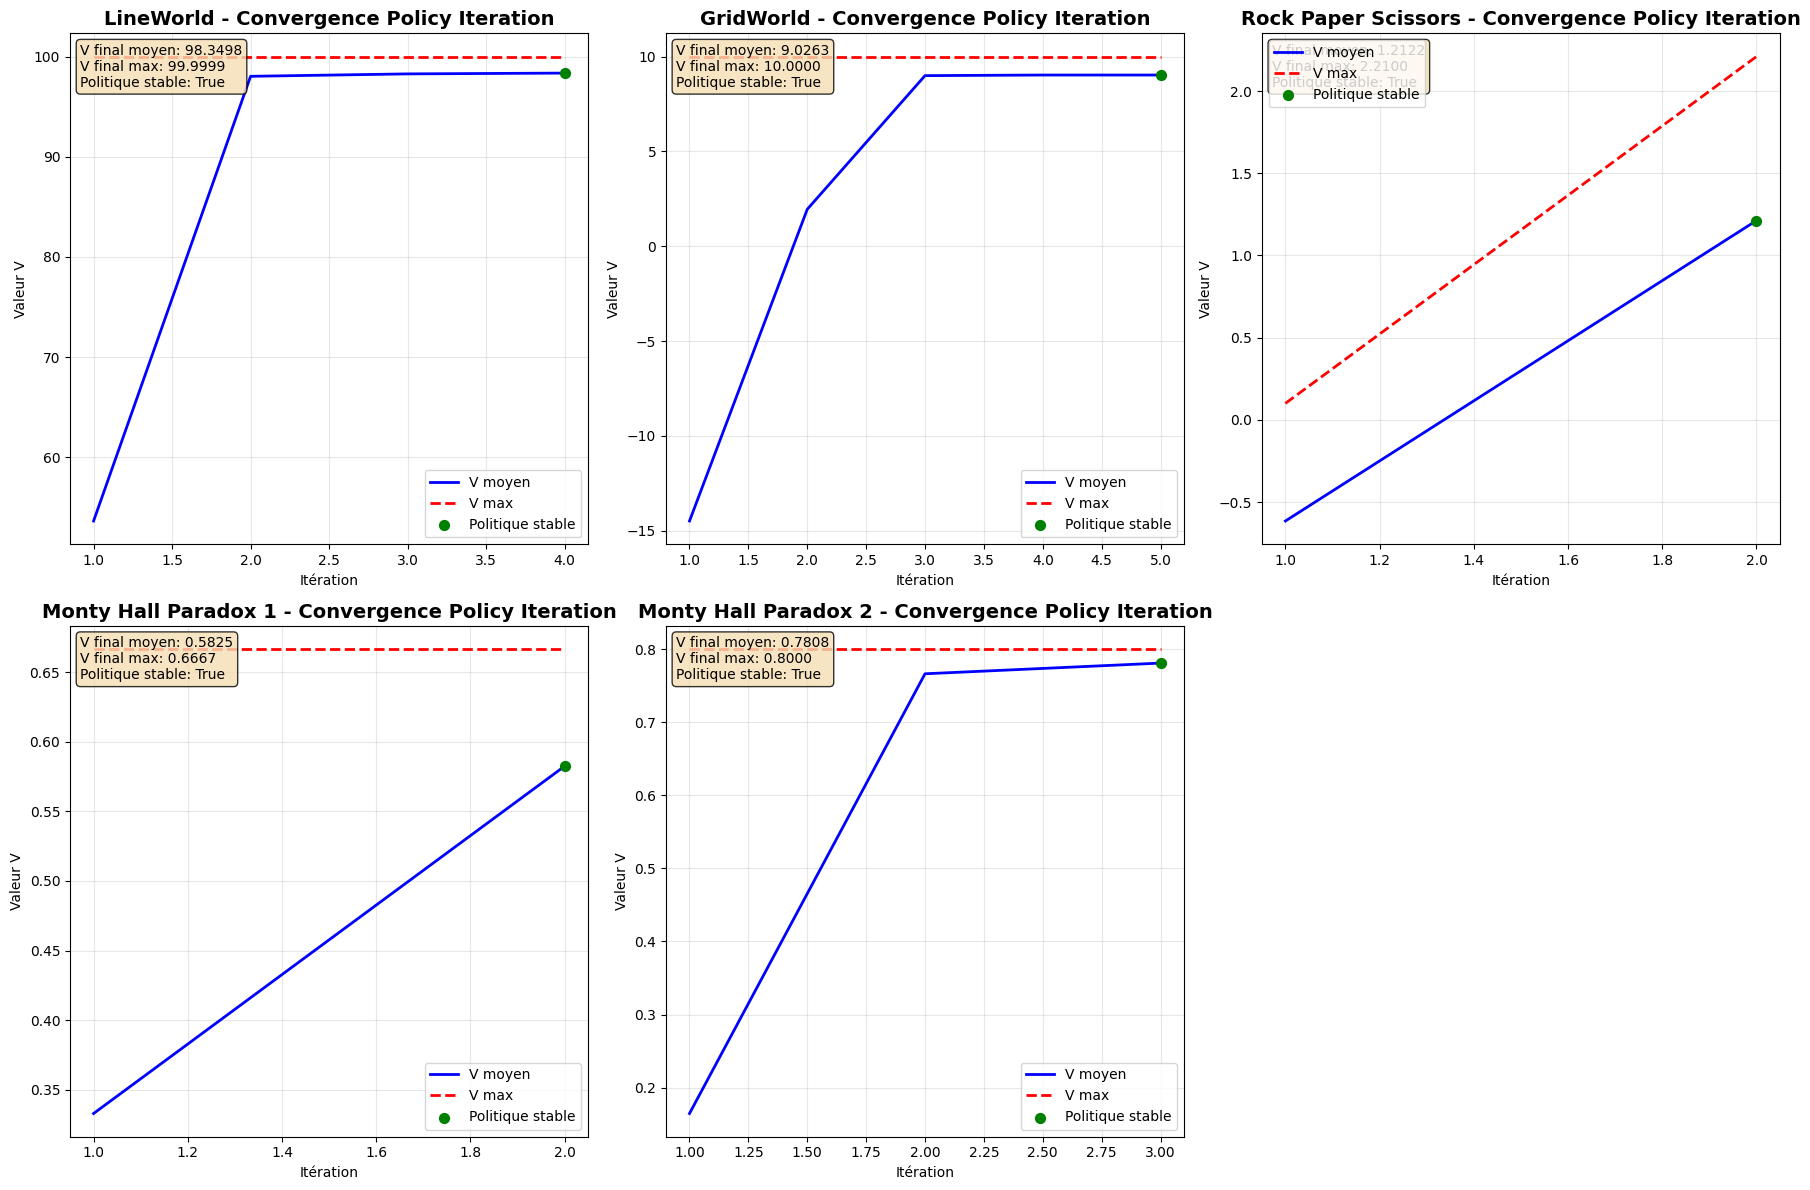

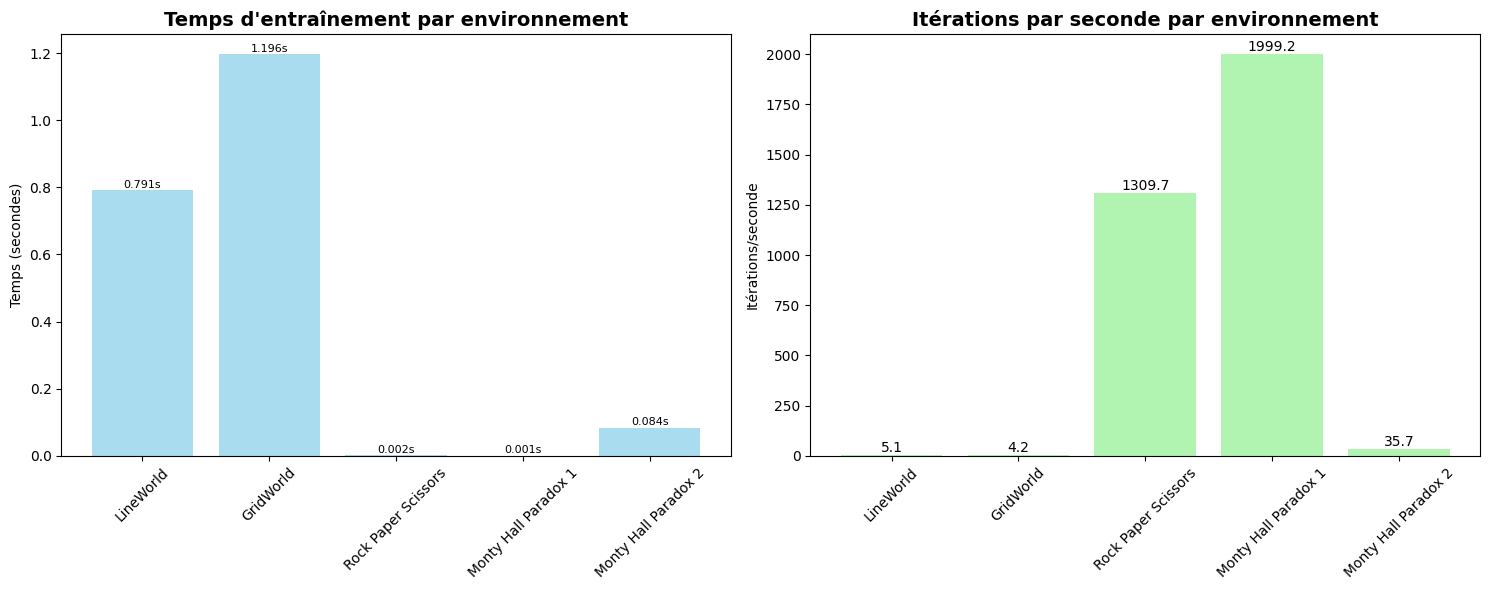

In [23]:
# Visualisation des résultats
plot_training_curves_pi(all_results_pi)

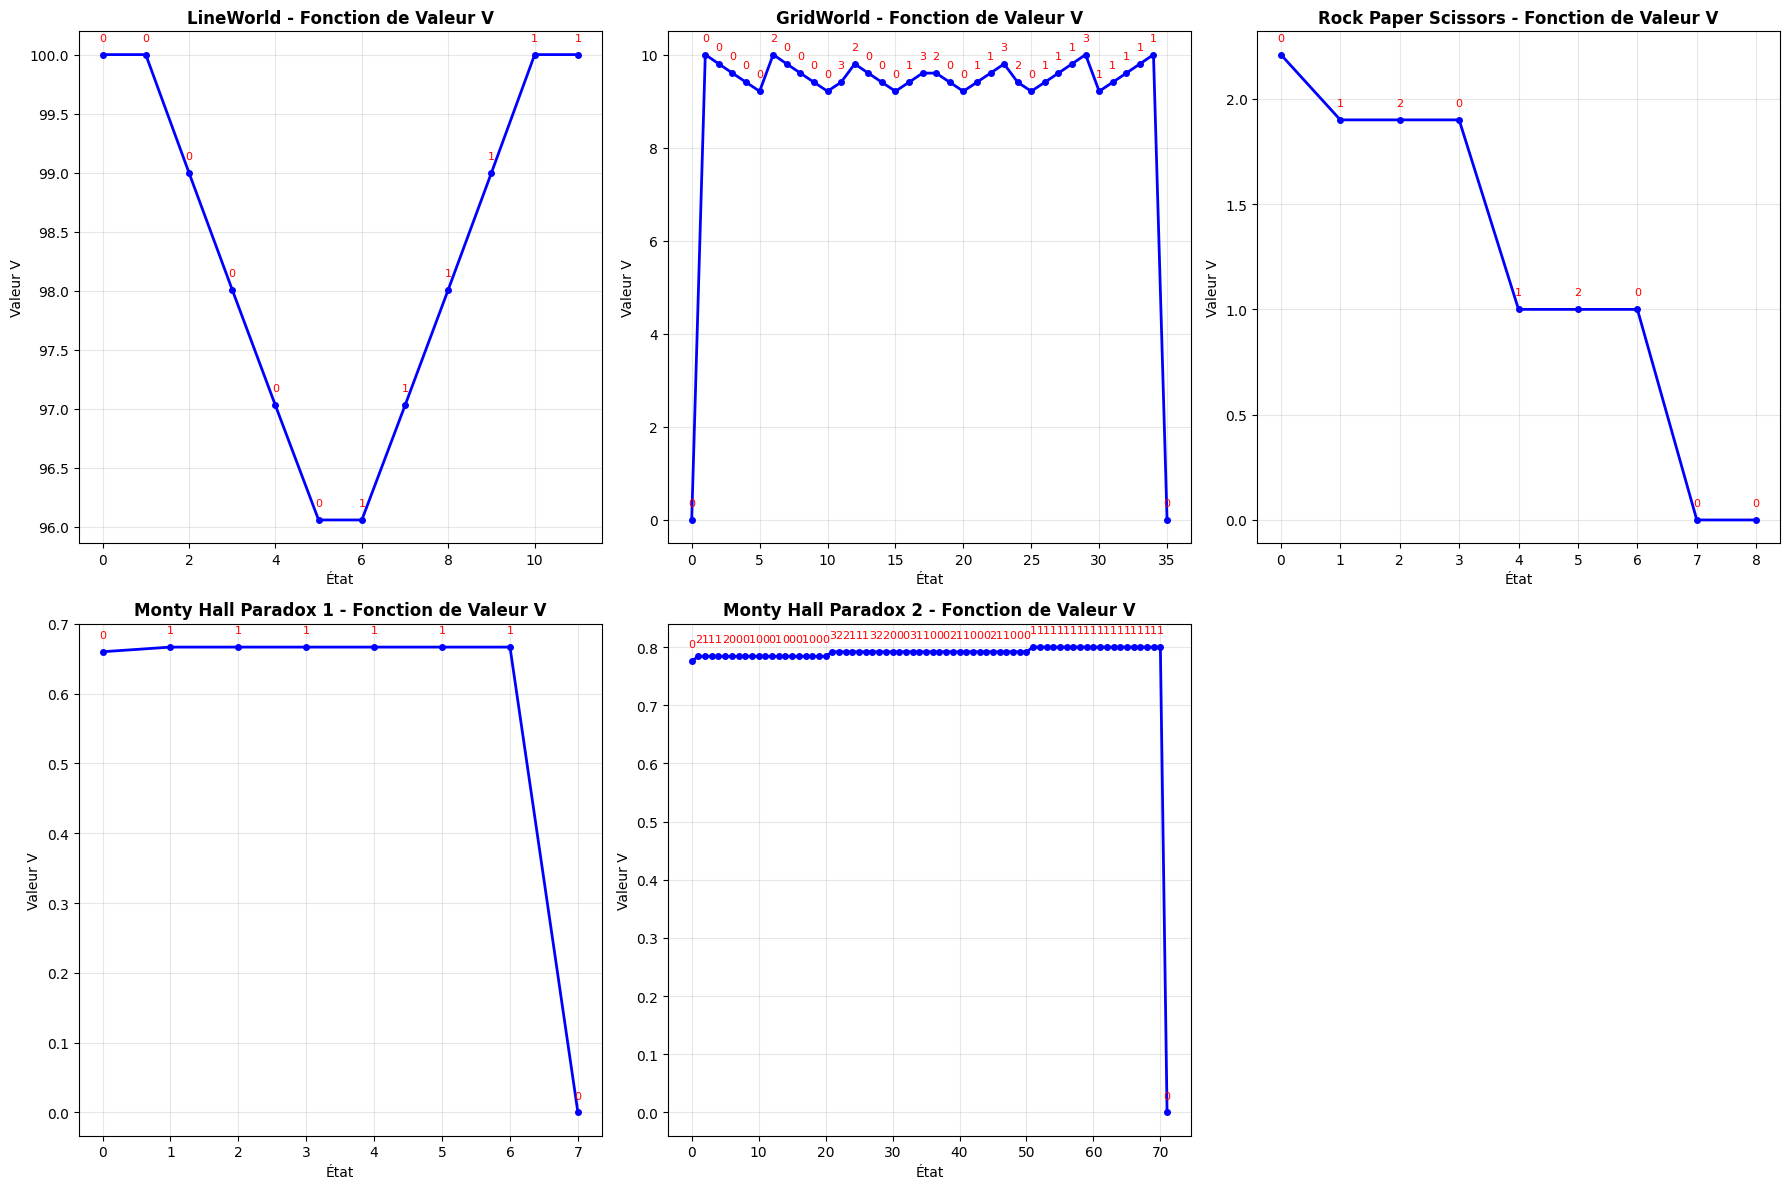

In [24]:
# Visualisation des politiques
visualize_policies_pi(all_results_pi)

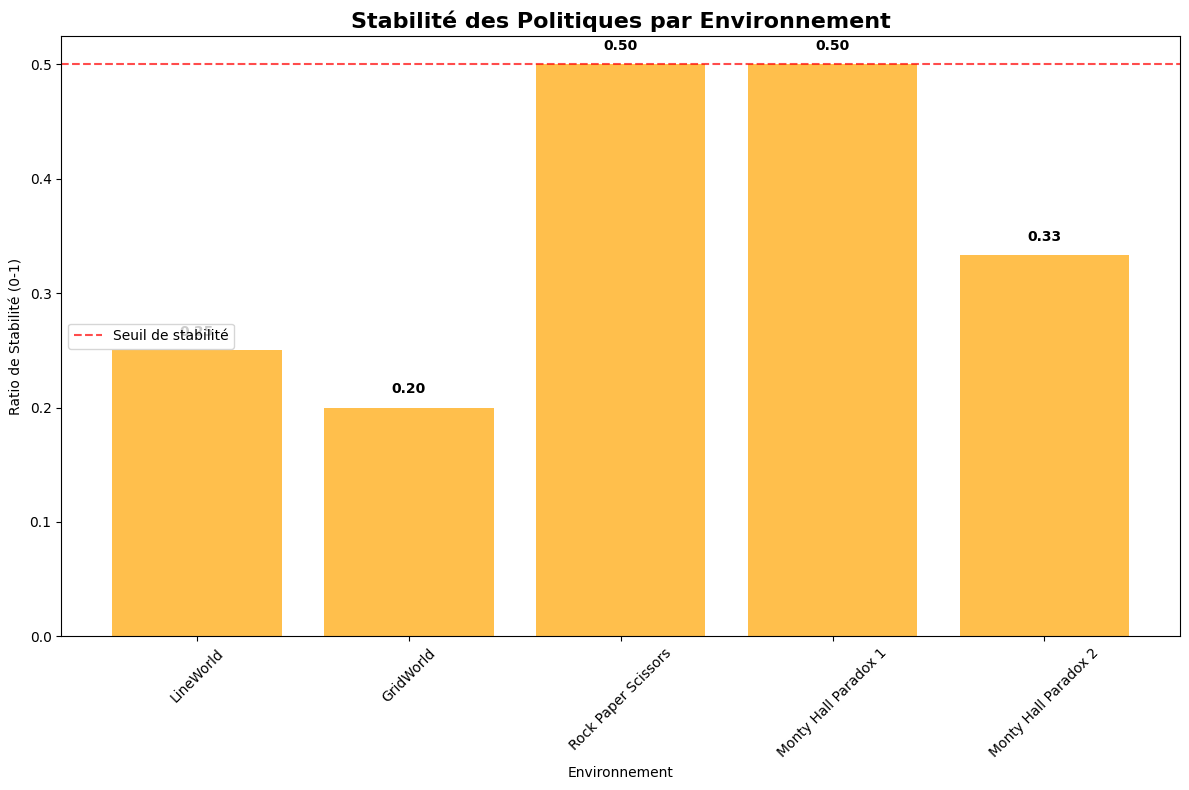

In [25]:
# Comparaison de stabilité des politiques
compare_policy_stability(all_results_pi)

In [26]:
# Analyse détaillée des politiques apprises
print("ANALYSE DÉTAILLÉE DES POLITIQUES APPRISES - POLICY ITERATION")
print("="*80)

for env_name, result in all_results_pi.items():
    if result:
        print(f"\n{result['env_name']}:")
        print(f"  Convergence: {result['converged']}")
        print(f"  Itérations: {result['iterations']}")
        print(f"  V-table shape: {result['V'].shape}")
        print(f"  V-table moyenne: {np.mean(result['V']):.6f}")
        print(f"  V-table max: {np.max(result['V']):.6f}")
        print(f"  V-table min: {np.min(result['V']):.6f}")
        
        # Analyser la stabilité de la politique
        if 'history' in result:
            history = result['history']
            policy_stable = [h['policy_stable'] for h in history]
            stability_ratio = sum(policy_stable) / len(policy_stable) if policy_stable else 0
            print(f"  Stabilité politique: {stability_ratio:.2f} ({sum(policy_stable)}/{len(policy_stable)} itérations stables)")
        
        # Afficher les meilleures actions par état
        if len(result['V'].shape) == 1:
            best_actions = np.argmax(result['policy'], axis=1) if len(result['policy'].shape) > 1 else result['policy']
            print(f"  Actions optimales par état: {best_actions}")
        else:
            print(f"  Politique optimale extraite")

ANALYSE DÉTAILLÉE DES POLITIQUES APPRISES - POLICY ITERATION

LineWorld:
  Convergence: True
  Itérations: 4
  V-table shape: (12,)
  V-table moyenne: 98.349819
  V-table max: 99.999902
  V-table min: 96.059502
  Stabilité politique: 0.25 (1/4 itérations stables)
  Actions optimales par état: [0 0 0 0 0 0 1 1 1 1 1 1]

GridWorld:
  Convergence: True
  Itérations: 5
  V-table shape: (36,)
  V-table moyenne: 9.026314
  V-table max: 10.000000
  V-table min: 0.000000
  Stabilité politique: 0.20 (1/5 itérations stables)
  Actions optimales par état: [0 0 0 0 0 0 2 0 0 0 0 3 2 0 0 0 1 3 2 0 0 1 1 3 2 0 1 1 1 3 1 1 1 1 1 0]

Rock Paper Scissors:
  Convergence: True
  Itérations: 2
  V-table shape: (9,)
  V-table moyenne: 1.212222
  V-table max: 2.210000
  V-table min: 0.000000
  Stabilité politique: 0.50 (1/2 itérations stables)
  Actions optimales par état: [0 1 2 0 1 2 0 0 0]

Monty Hall Paradox 1:
  Convergence: True
  Itérations: 2
  V-table shape: (8,)
  V-table moyenne: 0.582500
  V-tab

In [27]:
# Sauvegarde des résultats
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"policy_iteration_results_{timestamp}.pkl"

# Préparer les données pour la sauvegarde
save_data = {}
for env_name, result in all_results_pi.items():
    if result:
        save_data[env_name] = {
            'V': result['V'],
            'policy': result['policy'],
            'env_name': result['env_name'],
            'training_time': result['training_time'],
            'config': result['config'],
            'converged': result['converged'],
            'iterations': result['iterations']
        }
        if 'history' in result:
            save_data[env_name]['history'] = result['history']

with open(filename, 'wb') as f:
    pickle.dump(save_data, f)

print(f"\nRésultats Policy Iteration sauvegardés dans: {filename}")
print("\nTous les tests Policy Iteration sont terminés !")


Résultats Policy Iteration sauvegardés dans: policy_iteration_results_20250721_123448.pkl

Tous les tests Policy Iteration sont terminés !
